In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

def balance(X_temp, y_temp):
  smote = SMOTE()
  X_temp, y_temp= smote.fit_resample(X_temp, y_temp)
  return pd.concat([pd.DataFrame(X_temp), pd.DataFrame(y_temp)], axis=1)

In [ ]:
from joblib import Parallel, delayed
import joblib
  

def save_model(model,model_name):
 joblib.dump(model, model_name)
  
def load_model(model_name):
  return joblib.load(model_name)

In [ ]:
#!pip install shap
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import cross_val_score

def SHAP_EXP(model,X_test,features_names):
  graph_feat={
    "max_display":20,
    "shap_values Index":2
  }

  print("Model: ",model)

  explainer = shap.Explainer(model.predict, X_test)

  shap_values1 = explainer(X_test)

  if 'Subjects' in features_names:
    features_names.pop(0)


  shap.plots.bar(shap_values1,max_display=graph_feat["max_display"])

  print("---------------------")

  shap.summary_plot(shap_values1,max_display=graph_feat["max_display"],feature_names=features_names)

  print("---------------------")

  print("Local Explaination")
  shap.plots.waterfall(shap_values1[graph_feat["shap_values Index"]],max_display=graph_feat["max_display"])


  print("---------------------")

  shap.plots.bar(shap_values1[graph_feat["shap_values Index"]],max_display=graph_feat["max_display"])
    
    




# Confusion

In [ ]:
def confusion_details(y_test,y_pred):
    labels = list(set(y_test))
    labels.sort()

    print("Total labels: %s -> %s" % (len(labels), labels))

    df = pd.DataFrame(
        data=confusion_matrix(y_test, y_pred, labels=labels),
        columns=labels,
        index=labels
    )

    print(df)

    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Local (metrics per class)
    #
    tps = {}
    fps = {}
    fns = {}
    tns = {}

    precision_local = {}
    recall_local = {}
    f1_local = {}
    accuracy_local = {}
    specificity_local={}

    for label in labels:
        tps[label] = df.loc[label, label]
        fps[label] = df[label].sum() - tps[label]
        fns[label] = df.loc[label].sum() - tps[label]
        tns[label]=len(y_test) - (tps[label] + fps[label] + fns[label])
        
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        
        precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
        specificity_local[label] = tn / (tn + fp) if (tn + fp) > 0. else 0.
        recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
        p, r = precision_local[label], recall_local[label]
        
        f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
        accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.



    print("#-- Local measures --#")
    print("True Positives(TP):", tps)
    print("False Positives(FP):", fps)
    print("True Negatives(TN):", tns)
    print("False Negatives(FN):", fns)
    print("----------------------------")

    print("Precision:", precision_local)
    print("Recall/Sensitivity:", recall_local)
    print("Specificity:",specificity_local)
    print("F1-Score:", f1_local)
    print("Accuracy:", accuracy_local)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Global
    #
    micro_averages = {}
    macro_averages = {}

    correct_predictions = sum(tps.values())
    true_negative=sum(tns.values())

    den = sum(list(tps.values()) + list(fps.values()))
    micro_averages["Precision"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tps.values()) + list(fns.values()))
    micro_averages["Recall"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tns.values()) + list(fps.values()))
    micro_averages["Specificity"] = 1. * true_negative / den if den > 0. else 0.


    micro_avg_p, micro_avg_r = micro_averages["Precision"], micro_averages["Recall"]
    micro_averages["F1-score"] = 2. * micro_avg_p * micro_avg_r / (micro_avg_p + micro_avg_r) if (micro_avg_p + micro_avg_r) > 0. else 0.

    macro_averages["Precision"] = np.mean(list(precision_local.values()))
    macro_averages["Recall"] = np.mean(list(recall_local.values()))
    macro_averages["Specificity"]=np.mean(list(specificity_local.values()))


    macro_avg_p, macro_avg_r = macro_averages["Precision"], macro_averages["Recall"]
    macro_averages["F1-Score"] = 2. * macro_avg_p * macro_avg_r / (macro_avg_p + macro_avg_r) if (macro_avg_p + macro_avg_r) > 0. else 0.

    total_predictions = df.values.sum()
    accuracy_global = correct_predictions / total_predictions if total_predictions > 0. else 0.

    print("#-- Global measures --#")
    print("Micro-Averages:", micro_averages)
    print("Macro-Averages:", macro_averages)
    print("Correct predictions:", correct_predictions)
    print("Total predictions:", total_predictions)
    print("Accuracy:", accuracy_global)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()



    accuracy_local_new = {}
    for label in labels:
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        accuracy_local_new[label] = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0. else 0.

    total_true = sum(list(tps.values()) + list(tns.values()))
    total_predictions = sum(list(tps.values()) + list(tns.values()) + list(fps.values()) + list(fns.values()))
    accuracy_global_new = 1. * total_true / total_predictions if total_predictions > 0. else 0.

    print("Accuracy (per class), with TNs:", accuracy_local_new)
    print("Accuracy (per class), without TNs:", accuracy_local)
    print("Accuracy (global), with TNs:", accuracy_global_new)
    print("Accuracy (global), without TNs:", accuracy_global)

In [ ]:
#!pip install seaborn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def Con_Mat(y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize = (15,10))
  sn.heatmap(cm, annot=True, fmt='d',linewidth=.5) # here, cm is called to be visualized
  plt.xlabel('Predicted',fontsize=14.0, fontweight='bold')
  plt.ylabel('Truth',fontsize=12.0, fontweight='bold')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def Accurecy_Details(y_test,y_pred):    
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test,y_pred))
  print("Accurecy: ",accuracy_score(y_test, y_pred))

# ROC

In [60]:
!pip install plotly==5.11.0

In [63]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

def ploty_ROC(model,X,y):
    lebel_dict={
    0: "N1",
    1: "N2",
    2: "N3",
    3: "R",
    4: "W"
    }

    y_scores = model.predict_proba(X)

    y_onehot = pd.get_dummies(y, columns=model.classes_)

    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        name = f"{lebel_dict[y_onehot.columns[i]]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=1000, height=1000
    )
    fig.show()


# Main Code

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

dataset=pd.read_csv("EEG_Five_Stages_HMC.csv")


target="Sleep_Stage"

classes = np.array(sorted(list(set(dataset[target]))))

features = list(dataset.iloc[:0,1:])

In [ ]:
dataset.head()

In [ ]:

print("-------------------Before-------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)


from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
dataset[target]=encoder.fit_transform(dataset[target])


print("--------------------After--------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)

In [ ]:
X = dataset.loc[:, dataset.columns!=target]
y = dataset[target]



In [ ]:
"""from sklearn.preprocessing import label_binarize
cls=["N1", "N2","N3","R","W"]
y = label_binarize(y, classes=cls)"""

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [75]:

print("----------------------before------------------")
frequency = y_train.value_counts()
print(frequency)


new_dataset=balance(X_train,y_train)

X_train = new_dataset.loc[:, new_dataset.columns!=target]
y_train = new_dataset[target]


print("----------------------After------------------")
frequency = y_train.value_counts()
print(frequency)

----------------------before------------------
1    31537
2    17036
4    15551
3    13091
0     9545
Name: Sleep_Stage, dtype: int64
----------------------After------------------
0    31537
3    31537
2    31537
1    31537
4    31537
Name: Sleep_Stage, dtype: int64


# XGBoost

In [76]:
xg = load_model("XGBClassifier(n_estimators=8000,max_depth=14,random_state=0)")




In [77]:

y_pred=xg.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1113  536   10  247  462]
 [ 440 6662  408  243  138]
 [  70  587 3574    6   17]
 [ 192  216   14 2897   55]
 [ 310   64    3   26 3401]]
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      2368
           1       0.83      0.84      0.84      7891
           2       0.89      0.84      0.87      4254
           3       0.85      0.86      0.85      3374
           4       0.84      0.89      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8135632289889816


### Confusion

In [78]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1113   536    10   247   462
1   440  6662   408   243   138
2    70   587  3574     6    17
3   192   216    14  2897    55
4   310    64     3    26  3401

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1113, 1: 6662, 2: 3574, 3: 2897, 4: 3401}
False Positives(FP): {0: 1012, 1: 1403, 2: 435, 3: 522, 4: 672}
True Negatives(TN): {0: 18311, 1: 12397, 2: 17002, 3: 17795, 4: 17215}
False Negatives(FN): {0: 1255, 1: 1229, 2: 680, 3: 477, 4: 403}
----------------------------
Precision: {0: 0.5237647058823529, 1: 0.8260384376937384, 2: 0.8914941381890746, 3: 0.8473237788827143, 4: 0.8350110483672968}
Recall/Sensitivity: {0: 0.4700168918918919, 1: 0.8442529463946268, 2: 0.840150446638458, 3: 0.8586247777119146, 4: 0.8940588853838065}
Specificity: {

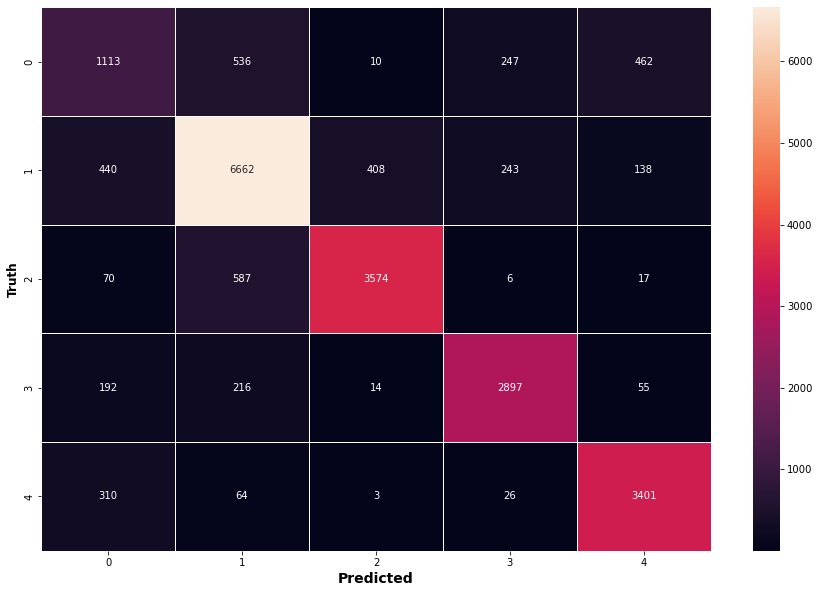

In [79]:
Con_Mat(y_test,y_pred)

### SHAP

Model:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


Permutation explainer: 101it [3:13:25, 116.05s/it]                          


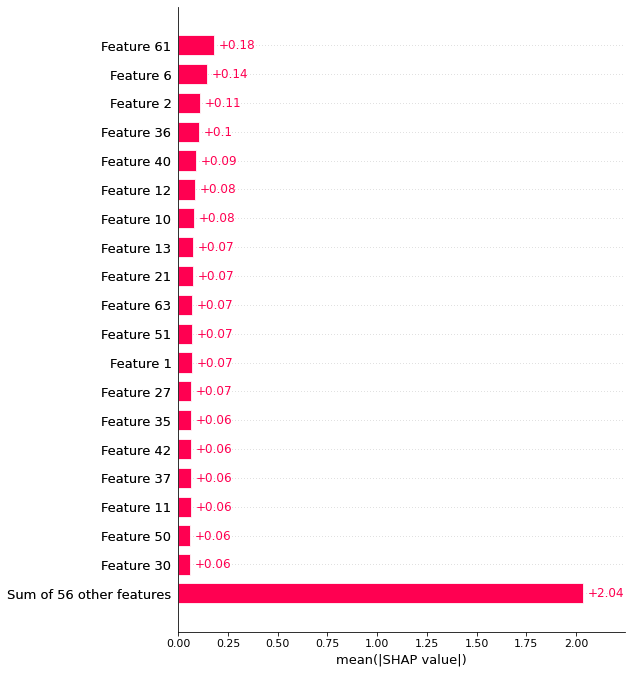

---------------------


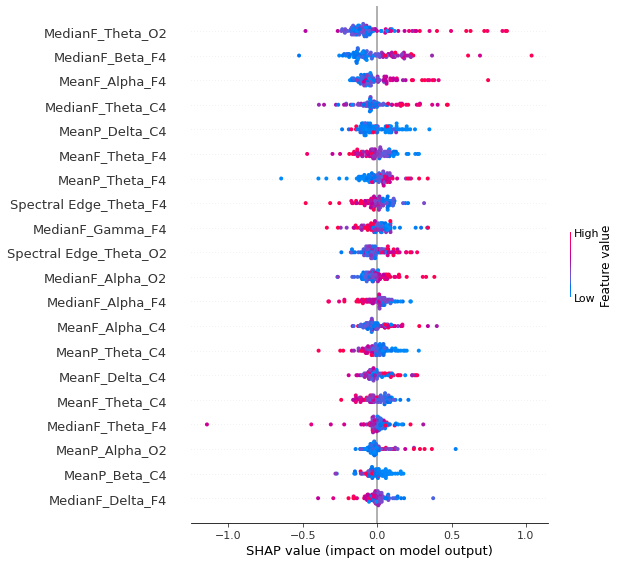

---------------------
Local Explaination


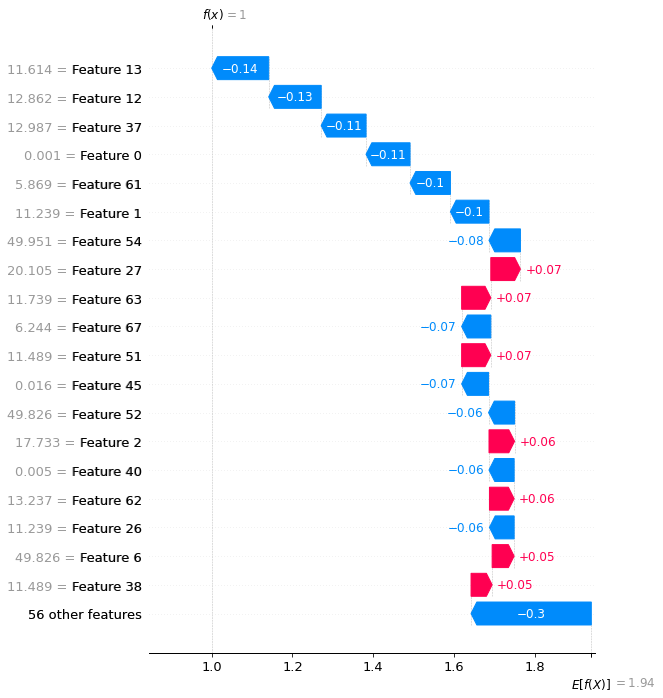

---------------------


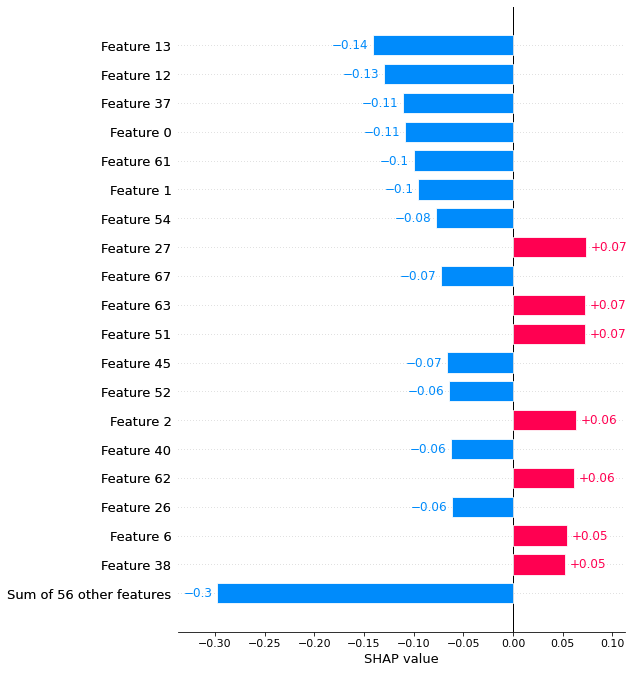

In [70]:
SHAP_EXP(xg,X_test.values[0:100],features)

### ROC TRAINING

In [80]:
ploty_ROC(xg,X_train,y_train)

### ROC TESTING

In [81]:
ploty_ROC(xg,X_test,y_test)

# GradientBoosting


In [82]:
gb = load_model("GradientBoostingClassifier(max_depth=14, n_estimators=4500)")


In [83]:

y_pred=gb.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1108  526    7  258  469]
 [ 401 6654  428  244  164]
 [  63  615 3549    6   21]
 [ 183  229    9 2884   69]
 [ 283   71    6   22 3422]]
              precision    recall  f1-score   support

           0       0.54      0.47      0.50      2368
           1       0.82      0.84      0.83      7891
           2       0.89      0.83      0.86      4254
           3       0.84      0.85      0.85      3374
           4       0.83      0.90      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8121801668894933


### Confusion

In [84]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1108   526     7   258   469
1   401  6654   428   244   164
2    63   615  3549     6    21
3   183   229     9  2884    69
4   283    71     6    22  3422

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1108, 1: 6654, 2: 3549, 3: 2884, 4: 3422}
False Positives(FP): {0: 930, 1: 1441, 2: 450, 3: 530, 4: 723}
True Negatives(TN): {0: 18393, 1: 12359, 2: 16987, 3: 17787, 4: 17164}
False Negatives(FN): {0: 1260, 1: 1237, 2: 705, 3: 490, 4: 382}
----------------------------
Precision: {0: 0.5436702649656526, 1: 0.8219888820259419, 2: 0.8874718679669917, 3: 0.8447568834212068, 4: 0.8255729794933655}
Recall/Sensitivity: {0: 0.46790540540540543, 1: 0.8432391331897098, 2: 0.8342736248236954, 3: 0.8547717842323651, 4: 0.8995793901156677}
Specificity: 

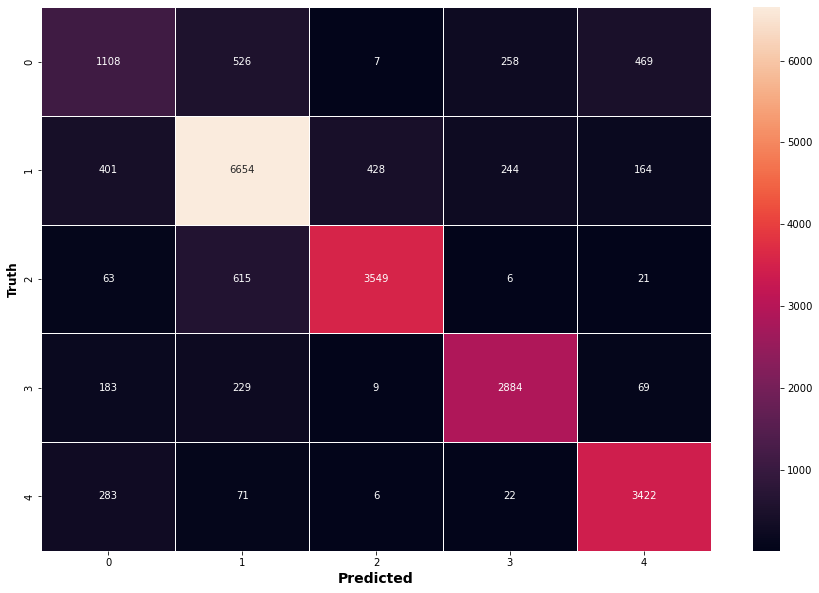

In [85]:
Con_Mat(y_test,y_pred)

### SHAP

In [ ]:
SHAP_EXP(gb,X_test.values[0:100],features)

### ROC TRAINING

In [86]:
ploty_ROC(gb,X_train,y_train)

### ROC TESTING

In [87]:
ploty_ROC(gb,X_test,y_test)

# Random Forest

In [88]:
rf = load_model("RandomForestClassifier(max_depth=49, random_state=0)")

In [72]:

y_pred=rf.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1221  352    7  296  492]
 [ 640 6052  613  391  195]
 [  76  581 3567    6   24]
 [ 258  196   17 2841   62]
 [ 357   54    9   30 3354]]
              precision    recall  f1-score   support

           0       0.48      0.52      0.50      2368
           1       0.84      0.77      0.80      7891
           2       0.85      0.84      0.84      4254
           3       0.80      0.84      0.82      3374
           4       0.81      0.88      0.85      3804

    accuracy                           0.79     21691
   macro avg       0.75      0.77      0.76     21691
weighted avg       0.79      0.79      0.79     21691

Accurecy:  0.785348762159421


### Confusion

In [73]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1221   352     7   296   492
1   640  6052   613   391   195
2    76   581  3567     6    24
3   258   196    17  2841    62
4   357    54     9    30  3354

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1221, 1: 6052, 2: 3567, 3: 2841, 4: 3354}
False Positives(FP): {0: 1331, 1: 1183, 2: 646, 3: 723, 4: 773}
True Negatives(TN): {0: 17992, 1: 12617, 2: 16791, 3: 17594, 4: 17114}
False Negatives(FN): {0: 1147, 1: 1839, 2: 687, 3: 533, 4: 450}
----------------------------
Precision: {0: 0.47844827586206895, 1: 0.8364892881824464, 2: 0.8466650842629955, 3: 0.7971380471380471, 4: 0.8126968742427914}
Recall/Sensitivity: {0: 0.515625, 1: 0.766949689519706, 2: 0.8385049365303244, 3: 0.8420272673384707, 4: 0.8817034700315457}
Specificity: {0: 0.9311

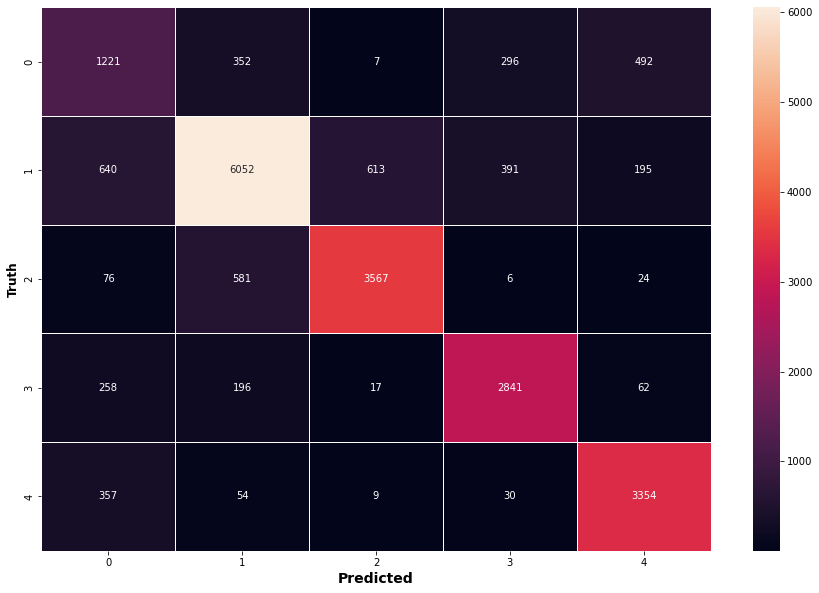

In [74]:
Con_Mat(y_test,y_pred)

### SHAP

In [ ]:
SHAP_EXP(rf,X_test.values[0:100],features)

### ROC TRAINING

In [89]:
ploty_ROC(rf,X_train,y_train)

### ROC TESTING

In [90]:
ploty_ROC(rf,X_test,y_test)